# U.S. Trip characteristics


The notebook is structured with the follow steps:
* 1. Business Understanding
* 2. Data Understanding (Exploration)
* 3. Data Preparation (ETL process)
* 4. Data Quality Validation
* 5. Analysis

### 1. Business Understanding

#### Analytic questions

1. Popular visa categories in 2016-02
2. The relationship between the trip to US city and the city's temperature in 2016-02
3. Population distribution across U.S. cities
4. Does the big city match the one with a lot of visitors

#### Data 

- I94 Immigration Data: This data comes from the US National Tourism and Trade Office. The data records each cased admitted to U.S. and a few personal information like gender or age.
- World Temperature Data: This dataset is compiled by Berkeley Earth Surface Temperature Study group. It records a average temperature across multiple cities in the world
- U.S. City Demographic Data: This data comes from OpenSoft. It includes basic population information of the city in addition to per-race size.
- Airport Code Table: The simple airport table is available from datahub.io. It includes basic metdata like name, municipality of airports across the world

In [1]:
import pandas as pd

In [2]:
pd.set_option('display.max_columns', None)

In [97]:
# I94 Immigration data
sasdf = pd.read_pickle('trip.pkl')

In [4]:
# Airport code table
airdf = pd.read_csv('airport-codes.csv')
airdf = airdf[airdf['iso_country'] == 'US']

In [ ]:
# Wolrd temperature data
tempdf = pd.read_csv('GlobalLandTemperaturesByCity.csv')
tempdf = tempdf[tempdf.AverageTemperature.notnull()].reset_index(drop=True)
tempdf = tempdf[tempdf['Country'] == 'United States']

In [ ]:
# U.S. city demographic data
demdf = pd.read_csv('us-cities-demographics.csv', delimiter=';')

In [ ]:
def parse_field_descrs(filename):
    '''
    Parse out U.S. visa descriptions
    
    :param filename: Visa description filepath
    :returns a dictionary of I94 data field description and visa/airport codes
    '''
    
    # Parse the field descriptions
    import re
    with open(filename) as f:
        sas_descr = f.read()
    pat = re.compile(r'/\*.+?\*/', re.DOTALL)
    matches = re.findall(pat, sas_descr)
    
    pat2 = re.compile(r'/\*\s+?(.+?)\s(?:-|is)\s(.+?)\s+\*/', re.DOTALL)
    out = dict(re.search(pat2, m).groups() for m in matches)
    
    # Create visa/airport value mapping dictionary
    lookups = {}
    lookups['visa'] = {1: 'Business', 2: 'Pleasure', 3: 'Student'}
    
    lookup_patterns = [
        re.compile(f'value.+?{patstr}\s+(.+?);', re.DOTALL)
        for patstr in ['i94prtl', 'i94addrl']]
    
    for pat3, name in zip(lookup_patterns, ['port', 'state']):
        kvstr = re.search(pat3, sas_descr).group(1)
        lookups[name] = {}
        for l in kvstr.splitlines():
            k, v = (v.strip().strip("'").strip() for v in l.split('='))
            lookups[name][k] = v
        
    return out, lookups

In [ ]:
field_dict, lookup_dict = parse_field_descrs('I94_field_description.txt')

### 2. Data Understanding
Pandas dataframe is used for quick exploration

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

##### Size of each raw dataset and Count of duplicate records

In [ ]:
fact_cols = ['cicid', 'i94yr', 'i94mon', 'i94port', 'i94visa', 
             'i94bir', 'biryear', 'gender', 'visatype', 'airline', 'fltno']

In [ ]:
dfs = [sasdf[fact_cols], tempdf, airdf, demdf]
dfnames = ['trip', 'temperature', 'airport', 'demographics']

In [18]:
for df, name in zip(dfs, dfnames):
    print(f'{name} table has {len(df)} records')
    print(f'{name} table has {df.duplicated().sum()} duplicate records')

trip table has 2570543 records
trip table has 0 duplicate records
temperature table has 661524 records
temperature table has 0 duplicate records
airport table has 22757 records
airport table has 0 duplicate records
demographics table has 2891 records
demographics table has 0 duplicate records


##### Columns with/without NULL values

- airport.iata_code has a lot of null values. These airport records need to be filtered out under the assumption that I94 immigration dataset has used this code for its airport code field
- airport.continent has a lot of null values but it won't be important because analytic question is only relevant to U.S. airports.
- All the other fields with null value are one of the characteristic columns and its ratio is not big.

Columns without NULL:
- trip table: cicid, i94yr, i94mon, i94port, i94visa, visatype
- temperature table: dt, AverageTemperature, AverageTemperatureUncertainty, City, Country, Latitude, Longitude
- airport table: ident, type, name, iso_country, iso_region, coordinates
- demographics table: City, State, Median Age, Total Population, State Code, Race, Count


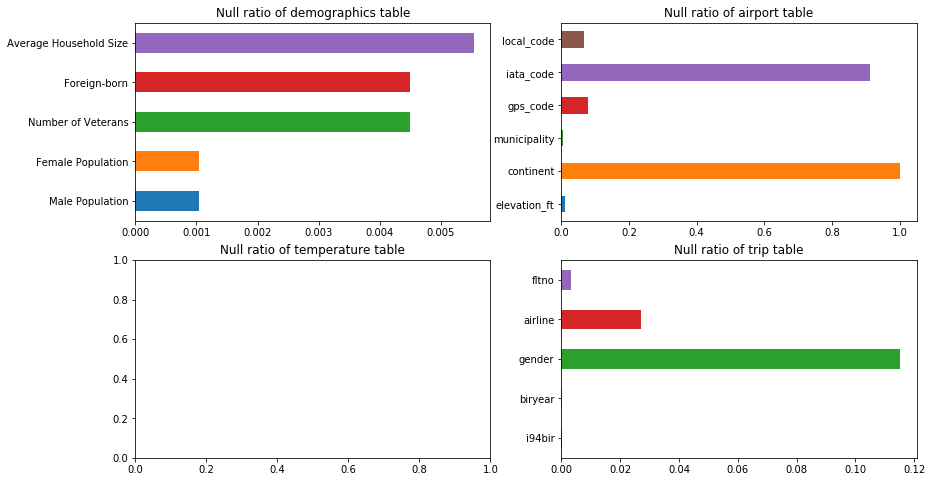

In [19]:
_, axes = plt.subplots(2, 2, figsize=(14, 8))
print('Columns without NULL:')
for df, name, ax in zip(dfs, dfnames, axes.flatten()[::-1]):
    null_df = df.isnull().sum() / float(len(df))
    print(f'- {name} table: {", ".join(null_df[null_df == 0].index)}')
    
    null_df = null_df[null_df != 0]
    if len(null_df) > 0:
        null_df.plot.barh(ax=ax)
    ax.set_title(f'Null ratio of {name} table')

#### Raw data samples

In [99]:
print('I94 Immigration table')
dfs[0].head(2)

I94 Immigration table


,cicid,i94yr,i94mon,i94port,i94visa,i94bir,biryear,gender,visatype,airline,fltno
0,2.0,2016.0,2.0,ATL,3.0,21.0,1995.0,F,F1,DL,241
1,5.0,2016.0,2.0,CHI,2.0,55.0,1961.0,F,B2,TK,5


In [19]:
print('Temperature table')
dfs[1].head(2)

Temperature table


,dt,AverageTemperature,AverageTemperatureUncertainty,City,Country,Latitude,Longitude
45983,1820-01-01,2.101,3.217,Abilene,United States,32.95N,100.53W
45984,1820-02-01,6.926,2.853,Abilene,United States,32.95N,100.53W


In [20]:
print('Airport table')
dfs[2].head(2)

Airport table


,ident,type,name,elevation_ft,continent,iso_country,iso_region,municipality,gps_code,iata_code,local_code,coordinates
0,00A,heliport,Total Rf Heliport,11.0,NaN,US,US-PA,Bensalem,00A,NaN,00A,"-74.93360137939453, 40.07080078125"
1,00AA,small_airport,Aero B Ranch Airport,3435.0,NaN,US,US-KS,Leoti,00AA,NaN,00AA,"-101.473911, 38.704022"


In [21]:
print('US city demographics table')
dfs[3].head(2)

US city demographics table


,City,State,Median Age,Male Population,Female Population,Total Population,Number of Veterans,Foreign-born,Average Household Size,State Code,Race,Count
0,Silver Spring,Maryland,33.8,40601.0,41862.0,82463,1562.0,30908.0,2.60,MD,Hispanic or Latino,25924
1,Quincy,Massachusetts,41.0,44129.0,49500.0,93629,4147.0,32935.0,2.39,MA,White,58723


##### Fields of interest

- airdf.iso_region has a specific format. 'US-' part will be removed because all the airports of interest are located in US

In [20]:
international_airdf = airdf[airdf.iata_code.notnull()]

In [23]:
international_airdf.iso_region.unique()

array(['US-FL', 'US-AK', 'US-CO', 'US-TX', 'US-MA', 'US-CA', 'US-AZ',
       'US-IN', 'US-WA', 'US-IL', 'US-MO', 'US-LA', 'US-NY', 'US-OK',
       'US-NC', 'US-PA', 'US-AL', 'US-NJ', 'US-MN', 'US-DC', 'US-OR',
       'US-KY', 'US-CT', 'US-WY', 'US-VA', 'US-NV', 'US-HI', 'US-MT',
       'US-IA', 'US-MD', 'US-NE', 'US-MI', 'US-UT', 'US-WI', 'US-SD',
       'US-NM', 'US-GA', 'US-NH', 'US-AR', 'US-SC', 'US-OH', 'US-KS',
       'US-TN', 'US-ND', 'US-ME', 'US-RI', 'US-MS', 'US-WV', 'US-ID',
       'US-VT', 'US-DE'], dtype=object)

- Airport and Temperature table both has coordinate information. They can be normalised into a same format of float type

In [24]:
airdf.loc[airdf.municipality == 'Boston', ['coordinates']].tail(2)

,coordinates
49583,"-71.024971, 42.351583"
49975,"-71.063223, 42.349037"


In [25]:
tempdf.loc[tempdf.City == 'Boston', ['Latitude', 'Longitude']].head(2)

,Latitude,Longitude
1008156,42.59N,72.00W
1008157,42.59N,72.00W


- Temperature table has data up to 2013 and I94 data includes only 2016 data. Therefore it requires a check if the most recent year temperature can be used as temperature in 2016
- Based on the year-by-year temperature graph, there won't be a big change in temperatue

In [105]:
print('Temperature data: ', tempdf.dt.min(), ' - ', tempdf.dt.max())

Temperature data:  1743-11-01  -  2013-09-01


In [21]:
city = 'Miami'
tdf = tempdf[(tempdf.City == city) & (tempdf.dt.str.startswith('2'))].sort_values('dt').copy()

In [22]:
tdf['dt'] = pd.to_datetime(tdf['dt'])

tdf['year'] = tdf['dt'].dt.year
tdf['month'] = tdf['dt'].dt.month

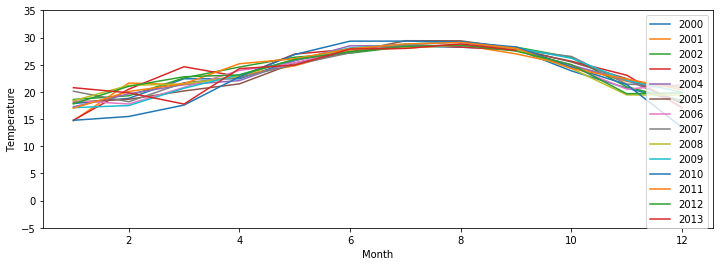

In [28]:
plt.figure(figsize=(12,4))
for yy in tdf.year.unique():
    xx = tdf[tdf.year == yy]
    plt.plot(xx.month, xx.AverageTemperature, label=yy)
plt.legend()
plt.ylim(-5, 35)
plt.ylabel('Temperature')
plt.xlabel('Month');

### 3. Data Preparation

##### US airport table

- Filtering
    - iso_country = 'US'
    - iata_code != NULL
        - iata_code will be used as a filed to join airport and immigration tables
    - type != 'closed'
        - because it can be assumed that closed airport is not used by U.S. visitors/travellers
- Transformation
    - data type transformation (for numerical fields)
    - Extract iso_state field value from iso_region field
    - Seperate coordinates value into longitude and latitude
    - Normalize municipality field value (lowercase all municipality names)
        - municipality field can be used to link this table with other tables
    
##### US demographics table

- Transformation
    - data type transformation (for numerical fields)
    - Normalize city field value (lowercase city names)
        - city field can be used to link this table with other tables
    - Race information field is removed
    - Duplicate city records are removed
    
    
##### US temperature table

- Filtering
    - country = 'United States'
    - date >= '2000-01-01'
        - It's assumed that recent years' temperature are good enough to show the temperature trend of 2016
    - average_temperature != NULL
        - NULL temperature data can't be used
- Transformation
    - data type transformation (for numerical and date fields)
    - Normalize city field value (lowercase city names)
        - city field can be used to link this table with other tables
    - Normalize longitude and latitude values to be in a same format as the US airport table
    - year, month columns are created from the date field

##### I94 Immigration table

- Transformation
    - data type transformation (for numerical fields)
    - municipality field is added by join with US airport table
    - visa_category field is changed from integer code into meaningful string value

In [108]:
def etl_airport_df(airdf=airdf):
    '''
    Apply ETL process on airport dataframe
    
    :param airdf: Dataframe of airpot data
    :return a cleaned version of airport dataframe
    '''
    
    # Filter US open airports
    filt = (airdf.iso_country == 'US') & (airdf.iata_code.notnull()) & (airdf.elevation_ft.notnull()) & (airdf.type != 'closed')
    airdf_cols = ['ident', 'type', 'name', 'elevation_ft', 'iso_region', 'municipality', 'iata_code', 'coordinates']
    airdf_clean = airdf.loc[filt, airdf_cols]
    
    # Data type casting
    airdf_clean['elevation_ft'] = airdf_clean['elevation_ft'].astype(int)
    
    # Field extraction / normalization
    airdf_clean['id'] = airdf_clean['ident']
    airdf_clean['iso_state'] = airdf_clean['iso_region'].str.split('-', expand=True)[0]
    airdf_clean['municipality'] = airdf_clean['municipality'].str.lower()
    airdf_coords = airdf_clean['coordinates'].str.split(',', expand=True)
    airdf_clean['longitude'] = airdf_coords[0].astype(float)
    airdf_clean['latitude'] = airdf_coords[1].astype(float)
    airdf_clean = airdf_clean.drop(['ident', 'iso_region', 'coordinates'], axis=1)
    
    return airdf_clean

In [110]:
def etl_demographic_df(demdf=demdf):
    '''
    Apply ETL process on demographics dataframe
    
    :param airdf: Dataframe of demographic data
    :return a cleaned version of demographic dataframe
    '''
    
    # Column name normalization
    dem_colnames = {
    'City': 'city', 'State': 'state', 'State Code': 'state_code',
    'Median Age': 'median_age', 'Male Population': 'male_population', 'Female Population': 'female_population',
    'Total Population': 'total_population', 'Number of Veterans': 'num_veterans',
    'Foreign-born': 'foreign_born_population', 'Average Household Size': 'average_household_size'}
    demdf_clean = demdf.rename(columns = dem_colnames)
    demdf_clean = demdf_clean[list(dem_colnames.values())]
    
    # Data type casting / normalization
    demdf_clean = demdf_clean.fillna(0)
    demdf_intcols = ['male_population', 'female_population', 'total_population', 'num_veterans', 'foreign_born_population']
    demdf_floatcols = ['median_age', 'average_household_size']
    demdf_clean[demdf_intcols] = demdf_clean[demdf_intcols].astype(int)
    demdf_clean[demdf_floatcols] = demdf_clean[demdf_floatcols].astype(float)
    demdf_clean['city'] = demdf_clean['city'].str.lower()
    
    # Drop duplicates
    demdf_clean = demdf_clean.drop_duplicates()
    
    return demdf_clean

In [112]:
def etl_temperature_df(demdf=demdf):
    '''
    Apply ETL process on temperature dataframe
    
    :param airdf: Dataframe of temperature data
    :return a cleaned version of temperature dataframe
    '''
    
    # Filter united states temperature after 2000
    filt = (tempdf.Country == 'United States') & (tempdf.dt >= '2000-01-01') & (tempdf.AverageTemperature.notnull())
    
    # Column name normalization
    temp_colnames = {
        'dt': 'date', 'Country': 'country', 'City': 'city', 
        'Longitude': 'longitude', 'Latitude': 'latitude',
        'AverageTemperature': 'average_temperature', 'AverageTemperatureUncertainty': 'average_temperature_uncertainty'
    }
    tempdf_clean = tempdf.rename(columns=temp_colnames)
    tempdf_clean = tempdf_clean.loc[filt, list(temp_colnames.values())]
    
    # Data type casting / normalization
    tempdf_floatcols = ['average_temperature', 'average_temperature_uncertainty']
    tempdf_clean[tempdf_floatcols] = tempdf_clean[tempdf_floatcols].astype(float)
    tempdf_clean['date'] = pd.to_datetime(tempdf_clean['date'])
    tempdf_clean['city'] = tempdf_clean['city'].str.lower()
    
    # Field extraction / normalization
    tempdf_clean['year'] = tempdf_clean['date'].dt.year
    tempdf_clean['month'] = tempdf_clean['date'].dt.month
    tempdf_clean['longitude'] = tempdf_clean['longitude'].str.rstrip('W').astype(float)
    tempdf_clean['latitude'] = tempdf_clean['latitude'].str.rstrip('N').astype(float)
    
    return tempdf_clean

In [113]:
def etl_trip_df(sasdf, airdf_clean, visa_lookup=lookup_dict):
    '''
    Apply ETL process on trip dataframe
    
    :param airdf: Dataframe of trip data
    :return a cleaned version of trip dataframe
    '''
    
    # Column name normalization
    sasdf_colnames = {
        'cicid': 'case_id', 'i94yr': 'case_year', 'i94mon': 'case_month',
        'i94port': 'airport_id', 'i94visa': 'visa_category', 'visatype': 'visa_type',
        'biryear': 'birth_year', 'i94bir': 'age', 'gender': 'gender', 'airline': 'airline_id', 'fltno': 'flight_number'
    }
    sasdf_clean = sasdf.rename(columns=sasdf_colnames)
    sasdf_clean = sasdf_clean.loc[(sasdf_clean.birth_year.notnull()) & (sasdf_clean.age.notnull()), list(sasdf_colnames.values())]
    
    # Data type casting
    sasdf_intcols = ['case_year', 'case_month', 'visa_category', 'birth_year', 'age']
    sasdf_clean[sasdf_intcols] = sasdf_clean[sasdf_intcols].astype(int)
    sasdf_clean['case_id'] = sasdf_clean['case_id'].astype('int64')

    # Table join / Field creation 
    sasdf_clean['visa_category'] = sasdf_clean['visa_category'].map(visa_lookup['visa'])
    airport_region_lookup = airdf_clean[['iata_code', 'municipality']].drop_duplicates()
    airport_region_lookup_dict = airport_region_lookup.set_index('iata_code').to_dict()
    sasdf_clean['municipality'] = sasdf_clean['airport_id'].map(airport_region_lookup_dict['municipality'])
    
    return sasdf_clean

In [114]:
airdf_clean = etl_airport_df()
demdf_clean = etl_demographic_df()
tempdf_clean = etl_temperature_df()
sasdf_clean = etl_trip_df(sasdf, airdf_clean)

### 4 Data Quality Validation

The following quality checks are done for the tables

- Unique ID constraints
    - Primary keys are checked if they can uniquely identify a row of the table
    - Primary keys should not be NULL
- Non-null constraints
    - The following feature columns should not be NULL
        - airport table: iata_code
        - demographics table: state_code
        - temperature table: average_temperature
        - US trip table: case_year, case_month, airport_id, visa_category, visa_type
- Data transformation check
    - The following tables checked if it only contains US relevant records
        - airport table
        - temperature table
    - temperature table's year field is checked if it's within 2010 ~ 2013

In [177]:
def check_airport_table(airdf_clean):
    '''
    Check data quality of airport table
    
    :param airdf_clean: airport table
    '''
    # Unique ID
    assert len(airdf_clean) == len(airdf_clean['id'].drop_duplicates())

    # Non-null
    cols = ['id', 'iata_code']
    assert airdf_clean[cols].isnull().sum().sum() == 0

In [178]:
def check_demographic_table(demdf_clean):
    '''
    Check data quality of demographic table
    
    :param demdf_clean: demographic table
    '''
    # Unique ID
    assert len(demdf_clean) == len(demdf_clean[['state', 'city']].drop_duplicates())

    # Non-null
    cols = ['state', 'state_code', 'city']
    assert demdf_clean[cols].isnull().sum().sum() == 0

    # State code mapping
    assert (len(demdf_clean['state_code'].drop_duplicates()) == 
        len(demdf_clean[['state', 'state_code']].drop_duplicates()))

In [179]:
def check_temperature_table(tempdf_clean):
    '''
    Check data quality of temperature table
    
    :param tempdf_clean: Temperature table
    '''
    # Unique ID
    assert len(tempdf_clean) == len(tempdf_clean[['date', 'city', 'longitude', 'latitude']].drop_duplicates())

    # Non-null
    cols = ['date', 'country', 'city', 'longitude', 'latitude', 'average_temperature']
    assert tempdf_clean[cols].isnull().sum().sum() == 0

    # US city temperature check
    assert len(tempdf_clean) == len(tempdf_clean[tempdf_clean['country'] == 'United States'])

    # Year range
    assert len(tempdf_clean[(tempdf_clean['year'] < 2000) | tempdf_clean['year'] > 2013]) == 0

In [180]:
def check_trip_table(sasdf_clean):
    '''
    Check data quality of trip table
    
    :param sasdf_clean: trip table
    '''

    # Unique ID
    assert len(sasdf_clean) == len(sasdf_clean['case_id'].drop_duplicates())

    # Non-null
    cols = ['case_id', 'case_year', 'case_month', 'airport_id', 'visa_category', 'visa_type']
    assert sasdf_clean[cols].isnull().sum().sum() == 0

In [182]:
check_airport_table(airdf_clean)
check_demographic_table(demdf_clean)
check_temperature_table(tempdf_clean)
check_trip_table(sasdf_clean)

### 5. Analysis

**Popular visa categories in 2016-02**
- The most popular visa is Pleasure/WT

In [124]:
visa_df = sasdf_clean.groupby(['visa_category', 'visa_type'])['case_id'].count().reset_index()
visa_df = visa_df.rename(columns={'case_id': 'cases'});

In [125]:
visa_df.sort_values('cases', ascending=False)

,visa_category,visa_type,cases
12,Pleasure,WT,1040385
7,Pleasure,B2,899270
6,Business,WB,251002
0,Business,B1,172354
10,Pleasure,GMT,113341
13,Student,F1,42641
8,Pleasure,CP,23168
2,Business,E2,16627
1,Business,E1,3298
14,Student,F2,3052


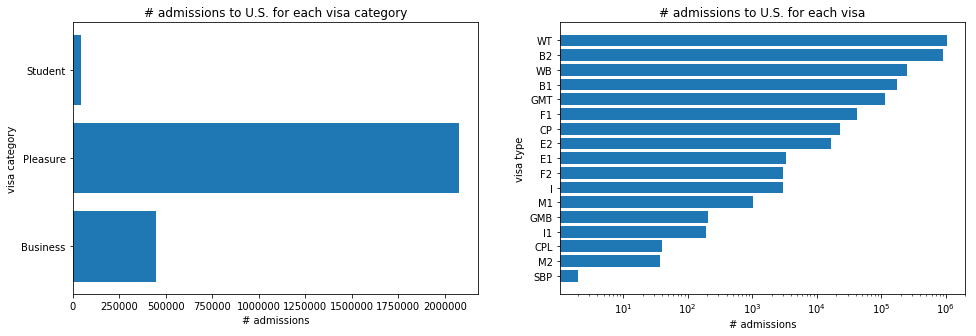

In [195]:
_, axes = plt.subplots(1, 2, figsize=(16, 5))
tdf = visa_df.groupby('visa_category')['cases'].sum()
axes[0].barh(tdf.index, tdf)
axes[0].set_title('# admissions to U.S. for each visa category')
axes[0].set_xlabel('# admissions')
axes[0].set_ylabel('visa category')

tdf2 = visa_df.sort_values('cases').reset_index()
axes[1].barh(range(len(tdf2)), tdf2['cases'].tolist(), log=True)
plt.yticks(range(len(tdf2)), tdf2['visa_type'])
axes[1].set_title('# admissions to U.S. for each visa')
axes[1].set_xlabel('# admissions')
axes[1].set_ylabel('visa type');

**The relationship between the trip to US city and the city's temperature in 2016-02**
- In 2016-02, city's temperature has a huge impact on the pleasure-type trip to U.S.
- Travellers (Pleasure-type visa) usually visit cities having warm temperature

In [84]:
def get_trip_temperature_df(sasdf_clean, tempdf_clean):
    '''
    Get a joined dataframe for average temperature of each city and traveller/visitors in Feburary
    
    :param sasdf_clean: Trip data dataframe
    :param tempdf_clean: Temperature data dataframe
    :return a joined dataframe of the 2 input dataframes
    '''
    
    # Calculate average temperature in Feburary
    city_feb_temp_avg = tempdf_clean[(tempdf_clean['month'] == 2)].groupby('city')['average_temperature'].mean()
    
    # Calculate travellers/visitors
    city_trips = sasdf_clean[sasdf_clean['municipality'].notnull()] \
        .groupby(['municipality', 'visa_category'])['case_id'].count().reset_index()
    
    # Join dataframes
    final_df = city_trips.join(city_feb_temp_avg, on='municipality', how='left')
    colnames = {'average_temperature': 'temp_avg', 'case_id': 'count'}
    final_df = final_df.rename(columns=colnames)
    final_df = final_df[(final_df['municipality'].notnull()) & (final_df['temp_avg'].notnull())]
    
    
    return final_df

In [85]:
final_pdf = get_trip_temperature_df(sasdf_clean, tempdf_clean)

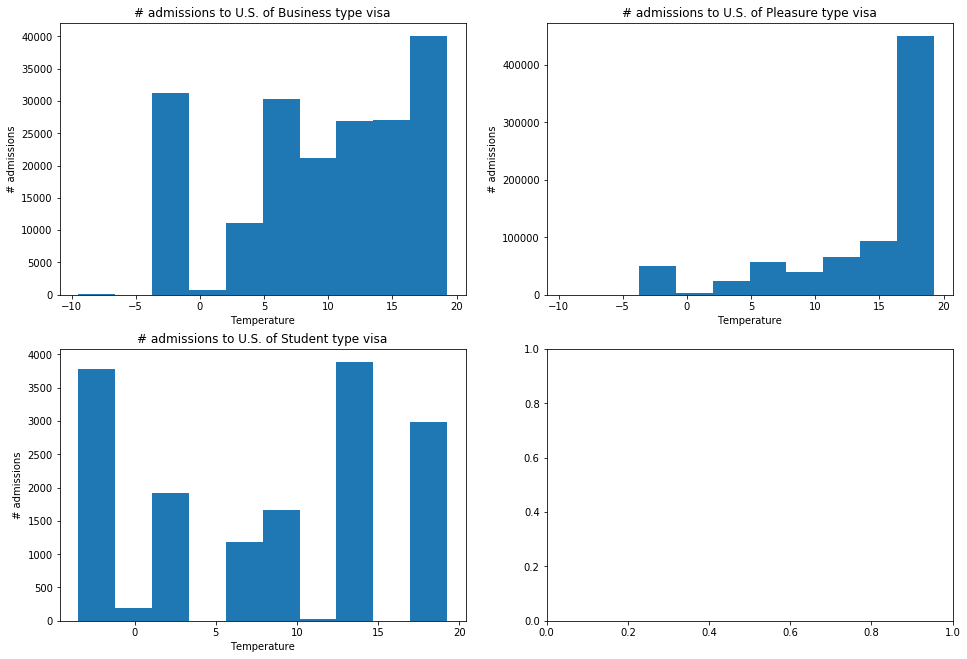

In [87]:
_, axes = plt.subplots(2, 2, figsize=(16, 11))

for visa, ax in zip(final_pdf.visa_category.unique(), axes.flatten()):
    tdf = final_pdf[final_pdf.visa_category == visa]
    ax.hist(tdf.temp_avg, weights=tdf['count'])
    ax.set_title(f'# admissions to U.S. of {visa} type visa')
    ax.set_ylabel('# admissions')
    ax.set_xlabel('Temperature')

**Top 10 largest U.S. cities in population**
- Largest city in population : New York
- Smallest citi in population: Carmichael

In [160]:
demdf_clean['state_city'] = demdf_clean['state'] + '/' + demdf_clean['city']

In [169]:
top10 = demdf_clean[['state_city', 'total_population']].sort_values('total_population', ascending=False).iloc[:10]
top10

,state_city,total_population
1826,New York/new york,8550405
40,California/los angeles,3971896
864,Illinois/chicago,2720556
254,Texas/houston,2298628
12,Pennsylvania/philadelphia,1567442
337,Arizona/phoenix,1563001
767,Texas/san antonio,1469824
236,California/san diego,1394907
538,Texas/dallas,1300082
561,California/san jose,1026919


In [167]:
demdf_clean[['state_city', 'total_population']].sort_values('total_population', ascending=False).tail()

,state_city,total_population
954,Illinois/skokie,64819
772,Ohio/youngs,64609
409,New York/brentwood,63792
182,Ohio/lorain,63651
307,California/carmichael,63215


Text(0.5,0,'population')

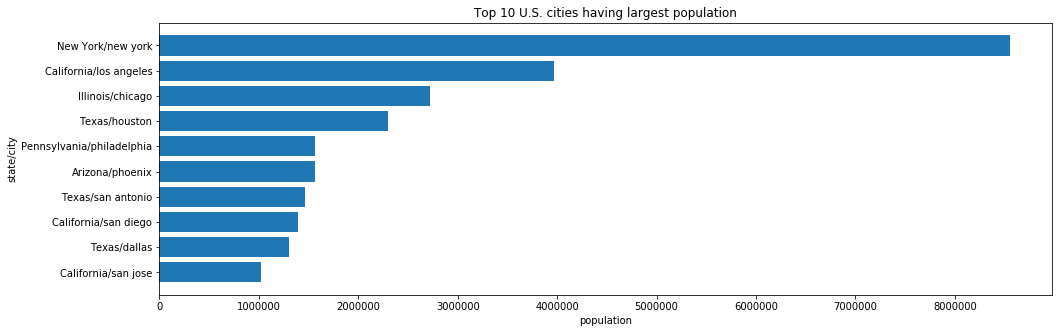

In [174]:
plt.figure(figsize=(16, 5))
plt.barh(range(10)[::-1], top10.total_population)
plt.yticks(range(10)[::-1], top10.state_city)
plt.title('Top 10 U.S. cities having largest population')
plt.ylabel('state/city')
plt.xlabel('population')

**Does the big city match the one with a lot of visitors**

In [193]:
cities_df = final_pdf.groupby('municipality')['count'].sum().sort_values(ascending=False)
cities_df.head(3)

municipality
miami          384675
new orleans    115389
orlando        109154
Name: count, dtype: int64

In [194]:
final_pdf[final_pdf.municipality.isin(cities_df.index[:3])][['municipality', 'temp_avg']].drop_duplicates() \
    .sort_values('temp_avg', ascending=False)

,municipality,temp_avg
148,miami,19.256714
173,orlando,17.658643
159,new orleans,13.782714
